In [4]:
%load_ext autoreload
%autoreload 2
import torch
import pandas as pd
import random, os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
import scipy

#
import utils
from model import MMBL, MLP

def set_random_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True
    os.environ['PYTHONHASHSEED'] = str(seed)
set_random_seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# mrna
mrna_data = pd.read_table('./data/TCGA-LIHC/HiSeqV2', index_col=0)
mrna_data = mrna_data.T
# survival
surv_data = pd.read_table('./data/TCGA-LIHC/survival_LIHC_survival.txt', index_col=0)
# clinical 
clic_data = pd.read_table('./data/TCGA-LIHC/TCGA.LIHC.sampleMap_LIHC_clinicalMatrix', index_col=0)
r"""3 interested columns:

sample_type
Primary Tumor          377
Solid Tissue Normal     59
Recurrent Tumor          2

pathologic_stage
Stage I          198
Stage II         100
Stage IIIA        74
Stage IIIB        10
Stage IIIC        10
Stage III          6
Stage IV           3
[Discrepancy]      2
Stage IVB          2
Stage IVA          1

adjacent_hepatic_tissue_inflammation_extent_type
Mild      116
Severe     22
"""

'3 interested columns:\n\nsample_type\nPrimary Tumor          377\nSolid Tissue Normal     59\nRecurrent Tumor          2\n\npathologic_stage\nStage I          198\nStage II         100\nStage IIIA        74\nStage IIIB        10\nStage IIIC        10\nStage III          6\nStage IV           3\n[Discrepancy]      2\nStage IVB          2\nStage IVA          1\n\nadjacent_hepatic_tissue_inflammation_extent_type\nMild      116\nSevere     22\n'

In [6]:
mrna_data

sample,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,RTN4RL2,...,TULP2,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
TCGA-FV-A495-01,11.1818,5.2482,4.1956,11.5047,9.5995,9.6257,11.8053,5.6835,0.0000,8.7486,...,0.0000,0.8379,6.1672,1.7494,8.0444,12.3759,8.0357,13.5037,8.7327,10.4145
TCGA-G3-A3CH-11,11.0186,5.3847,0.0000,11.6690,11.3980,10.8249,11.5487,3.5408,1.4714,7.9144,...,0.0000,3.5408,5.5302,0.0000,7.5066,10.5302,7.3741,13.0045,7.0466,10.3411
TCGA-CC-A3MB-01,11.2430,4.0013,0.0000,12.0791,9.8248,10.5608,12.1228,3.5582,0.0000,7.9795,...,0.4699,2.1586,3.1834,0.0000,8.8500,9.5592,8.5064,12.9815,2.9873,10.9926
TCGA-BC-A3KF-01,11.1612,2.9374,0.0000,12.5931,9.9459,10.5179,12.5044,1.7444,0.0000,10.3039,...,0.4770,0.8347,3.5813,0.4770,8.6376,10.3457,8.3303,13.5581,4.5197,13.2960
TCGA-DD-A4NV-01,12.0167,4.7857,0.0000,11.4616,10.8368,10.1428,12.9470,3.8613,0.0000,9.0306,...,0.0000,3.5402,3.7620,0.0000,7.9929,11.4056,8.1968,13.8179,7.2957,11.0316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-BC-A10Z-11,11.4769,3.2030,0.0000,11.8040,11.0430,10.7195,11.5175,2.6378,0.0000,7.4987,...,0.0000,3.6938,3.7747,0.0000,7.9147,11.0966,6.8846,12.6138,6.3636,10.5688
TCGA-ZP-A9CY-01,11.8403,4.5229,0.0000,11.7526,10.8700,10.5485,12.1835,4.1139,0.0000,8.4830,...,0.0000,1.9401,4.5667,0.0000,8.0722,11.2082,7.9450,13.1783,6.6483,10.2337
TCGA-DD-A39Y-01,11.5943,0.0000,0.0000,12.1408,10.6295,9.7536,12.0181,2.1912,0.0000,9.1556,...,0.0000,0.9197,4.2006,5.4675,6.7248,9.1226,6.1130,12.4996,3.7046,10.2489
TCGA-DD-A115-01,11.7589,3.7591,0.0000,12.0914,11.5774,10.1702,12.0789,4.3081,0.0000,11.0616,...,2.8619,2.8619,4.1258,0.0000,7.5925,11.2591,8.0674,13.3772,6.4848,9.8594


In [7]:
surv_data

,_PATIENT,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction
sample,,,,,,,,,,
TCGA-2V-A95S-01,TCGA-2V-A95S,0,NaN,0.0,NaN,0.0,NaN,0,NaN,NaN
TCGA-2Y-A9GS-01,TCGA-2Y-A9GS,1,724.0,1.0,724.0,1.0,102.0,1,102.0,NaN
TCGA-2Y-A9GT-01,TCGA-2Y-A9GT,1,1624.0,1.0,1624.0,1.0,1083.0,1,1083.0,NaN
TCGA-2Y-A9GU-01,TCGA-2Y-A9GU,0,1939.0,0.0,1939.0,0.0,1939.0,0,1939.0,NaN
TCGA-2Y-A9GV-01,TCGA-2Y-A9GV,1,2532.0,1.0,2532.0,0.0,2532.0,1,1745.0,NaN
...,...,...,...,...,...,...,...,...,...,...
TCGA-ZS-A9CD-01,TCGA-ZS-A9CD,1,1386.0,NaN,1386.0,1.0,371.0,1,371.0,NaN
TCGA-ZS-A9CE-01,TCGA-ZS-A9CE,0,1241.0,0.0,1241.0,0.0,1241.0,1,892.0,NaN
TCGA-ZS-A9CF-02,TCGA-ZS-A9CF,0,2412.0,0.0,2412.0,1.0,636.0,1,636.0,NaN


In [8]:
clic_data

,_INTEGRATION,_PATIENT,_cohort,_primary_disease,_primary_site,additional_pharmaceutical_therapy,additional_radiation_therapy,adjacent_hepatic_tissue_inflammation_extent_type,age_at_initial_pathologic_diagnosis,albumin_result_lower_limit,...,_GENOMIC_ID_TCGA_LIHC_exp_HiSeqV2_percentile,_GENOMIC_ID_TCGA_LIHC_mutation_bcgsc_gene,_GENOMIC_ID_data/public/TCGA/LIHC/miRNA_HiSeq_gene,_GENOMIC_ID_TCGA_LIHC_PDMRNAseqCNV,_GENOMIC_ID_TCGA_LIHC_exp_HiSeqV2_exon,_GENOMIC_ID_TCGA_LIHC_mutation_ucsc_maf_gene,_GENOMIC_ID_TCGA_LIHC_exp_HiSeqV2,_GENOMIC_ID_TCGA_LIHC_exp_HiSeqV2_PANCAN,_GENOMIC_ID_TCGA_LIHC_mutation_broad_gene,_GENOMIC_ID_TCGA_LIHC_hMethyl450
sampleID,,,,,,,,,,,,,,,,,,,,,
TCGA-2V-A95S-01,TCGA-2V-A95S-01,TCGA-2V-A95S,TCGA Liver Cancer (LIHC),liver hepatocellular carcinoma,Liver,NaN,NaN,Severe,NaN,3.5,...,53796be6-1c87-448a-9928-3c640e9d3414,NaN,TCGA-2V-A95S-01,TCGA-2V-A95S-01,53796be6-1c87-448a-9928-3c640e9d3414,NaN,53796be6-1c87-448a-9928-3c640e9d3414,53796be6-1c87-448a-9928-3c640e9d3414,NaN,TCGA-2V-A95S-01A-11D-A36Y-05
TCGA-2Y-A9GS-01,TCGA-2Y-A9GS-01,TCGA-2Y-A9GS,TCGA Liver Cancer (LIHC),liver hepatocellular carcinoma,Liver,NaN,NaN,NaN,58.0,3.5,...,7b0d0cd1-3770-4e1c-9a64-93e41825a3b7,NaN,TCGA-2Y-A9GS-01,TCGA-2Y-A9GS-01,7b0d0cd1-3770-4e1c-9a64-93e41825a3b7,NaN,7b0d0cd1-3770-4e1c-9a64-93e41825a3b7,7b0d0cd1-3770-4e1c-9a64-93e41825a3b7,NaN,TCGA-2Y-A9GS-01A-12D-A383-05
TCGA-2Y-A9GT-01,TCGA-2Y-A9GT-01,TCGA-2Y-A9GT,TCGA Liver Cancer (LIHC),liver hepatocellular carcinoma,Liver,NaN,NaN,NaN,51.0,3.5,...,e1ab65b5-ee17-4e86-93aa-446c8f387ef1,NaN,TCGA-2Y-A9GT-01,TCGA-2Y-A9GT-01,e1ab65b5-ee17-4e86-93aa-446c8f387ef1,NaN,e1ab65b5-ee17-4e86-93aa-446c8f387ef1,e1ab65b5-ee17-4e86-93aa-446c8f387ef1,NaN,TCGA-2Y-A9GT-01A-11D-A383-05
TCGA-2Y-A9GU-01,TCGA-2Y-A9GU-01,TCGA-2Y-A9GU,TCGA Liver Cancer (LIHC),liver hepatocellular carcinoma,Liver,NaN,NaN,NaN,55.0,3.5,...,6f3f7f73-b031-424e-ba7c-263f802dd6cf,NaN,TCGA-2Y-A9GU-01,TCGA-2Y-A9GU-01,6f3f7f73-b031-424e-ba7c-263f802dd6cf,NaN,6f3f7f73-b031-424e-ba7c-263f802dd6cf,6f3f7f73-b031-424e-ba7c-263f802dd6cf,NaN,TCGA-2Y-A9GU-01A-11D-A383-05
TCGA-2Y-A9GV-01,TCGA-2Y-A9GV-01,TCGA-2Y-A9GV,TCGA Liver Cancer (LIHC),liver hepatocellular carcinoma,Liver,NaN,NaN,NaN,54.0,3.5,...,c0bcdbc7-9bed-49b7-93ca-f82ffc2929a1,NaN,TCGA-2Y-A9GV-01,TCGA-2Y-A9GV-01,c0bcdbc7-9bed-49b7-93ca-f82ffc2929a1,NaN,c0bcdbc7-9bed-49b7-93ca-f82ffc2929a1,c0bcdbc7-9bed-49b7-93ca-f82ffc2929a1,NaN,TCGA-2Y-A9GV-01A-11D-A383-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-ZS-A9CD-01,TCGA-ZS-A9CD-01,TCGA-ZS-A9CD,TCGA Liver Cancer (LIHC),liver hepatocellular carcinoma,Liver,NaN,NaN,Mild,73.0,36.0,...,35c7281c-ffe6-4fc4-b3de-da4f6a113397,NaN,TCGA-ZS-A9CD-01,TCGA-ZS-A9CD-01,35c7281c-ffe6-4fc4-b3de-da4f6a113397,NaN,35c7281c-ffe6-4fc4-b3de-da4f6a113397,35c7281c-ffe6-4fc4-b3de-da4f6a113397,NaN,TCGA-ZS-A9CD-01A-11D-A36Y-05
TCGA-ZS-A9CE-01,TCGA-ZS-A9CE-01,TCGA-ZS-A9CE,TCGA Liver Cancer (LIHC),liver hepatocellular carcinoma,Liver,NO,NO,NaN,79.0,36.0,...,d8b053f6-2674-43ec-9c36-ed652fe5ff7e,NaN,TCGA-ZS-A9CE-01,TCGA-ZS-A9CE-01,d8b053f6-2674-43ec-9c36-ed652fe5ff7e,NaN,d8b053f6-2674-43ec-9c36-ed652fe5ff7e,d8b053f6-2674-43ec-9c36-ed652fe5ff7e,NaN,TCGA-ZS-A9CE-01A-11D-A36Y-05
TCGA-ZS-A9CF-01,TCGA-ZS-A9CF-01,TCGA-ZS-A9CF,TCGA Liver Cancer (LIHC),liver hepatocellular carcinoma,Liver,NO,NO,NaN,64.0,36.0,...,b6a5831d-1a97-49f1-8dbc-c833abb60a20,NaN,TCGA-ZS-A9CF-01,TCGA-ZS-A9CF-01,b6a5831d-1a97-49f1-8dbc-c833abb60a20,NaN,b6a5831d-1a97-49f1-8dbc-c833abb60a20,b6a5831d-1a97-49f1-8dbc-c833abb60a20,NaN,TCGA-ZS-A9CF-01A-11D-A383-05


In [9]:
clic = clic_data[~(clic_data['sample_type']=='Recurrent Tumor')].copy()
patients = np.intersect1d(np.intersect1d(mrna_data.index, surv_data.index), clic.index)
pos_sel = clic['sample_type'][clic['sample_type']=='Primary Tumor'].sample(50, random_state=0).index
neg_sel = clic['sample_type'][clic['sample_type']=='Solid Tissue Normal'].index
patients = np.intersect1d(patients, np.concatenate([pos_sel, neg_sel]))
clic = clic.loc[patients, :]
mrna_data = mrna_data.loc[patients, :]
surv_data = surv_data.loc[patients, :]

y = clic['sample_type']
y = y.map({'Primary Tumor': 1, 'Solid Tissue Normal': 0}).values

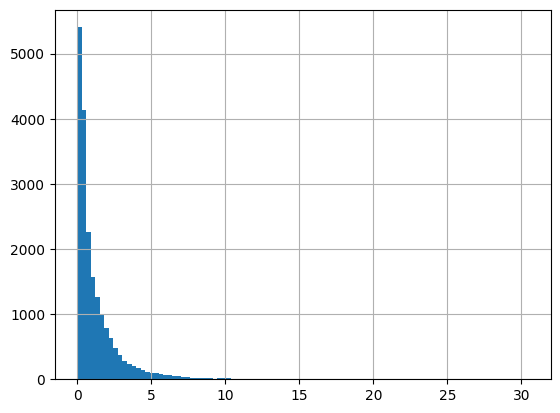

In [10]:
assert ~mrna_data.isna().any().any() # check missing values
mrna_data = mrna_data.loc[~mrna_data.index.duplicated()] # remove duplicated rows
mrna_data = mrna_data.loc[:,~mrna_data.columns.duplicated()] # remove duplicated features
mrna_data = mrna_data.iloc[:, ~((mrna_data == 0).sum(axis=0)==mrna_data.shape[0]).values] # remove features with 0 across all samples

mrna_data.var(axis=0).hist(bins=100); plt.show()
hvgs = mrna_data.var(axis=0).sort_values(ascending=False)[:2000] # TODO
mrna_data_sel = mrna_data.loc[:, hvgs.index]
# X = StandardScaler().fit_transform(mrna_data) # TODO

# scaling
X = StandardScaler().fit_transform(mrna_data_sel)

In [11]:
pvals = {}
for gene in mrna_data.columns:
    _, p = scipy.stats.mannwhitneyu(
        mrna_data[gene][y==1], 
        mrna_data[gene][y==0])
    pvals[gene] = p

In [12]:
pvals = pd.Series(pvals)
pvals = pvals.sort_values()
pvals = pvals[pvals<0.05]
pvals=pvals.to_frame()
pvals = pvals.rename(columns={0:'p'})
pvals['rank'] = np.arange(pvals.shape[0])

pvals.loc['TP53']

KeyError: 'TP53'

In [13]:
pvals.loc['AFP']

p          0.002933
rank    8721.000000
Name: AFP, dtype: float64

In [14]:
mrna_data['TP53']

TCGA-2Y-A9GS-01    10.2014
TCGA-2Y-A9GW-01    10.5193
TCGA-2Y-A9GX-01     9.7730
TCGA-2Y-A9H1-01     9.9046
TCGA-2Y-A9H6-01    10.6821
                    ...   
TCGA-RG-A7D4-01    10.3075
TCGA-WX-AA44-01     8.5924
TCGA-XR-A8TC-01     9.5418
TCGA-ZP-A9CY-01     9.6700
TCGA-ZS-A9CG-01     9.3015
Name: TP53, Length: 100, dtype: float64

In [15]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
train_idx, test_idx = next(sss.split(X, y))
X_trn, X_tst = X[train_idx], X[test_idx]
y_trn, y_tst = y[train_idx], y[test_idx]

In [16]:
model = MMBL(
    n_genes = X_trn.shape[1],
    emb_dim = 64,
    mlp_channels = [X_trn.shape[1], 128, 1],
    n_heads = 1,
)

# model = MLP([X_trn.shape[1], 128, 128, 128, 1])

# model = MMBL(
#     n_genes = X_trn.shape[1],
#     emb_dim = 8,
#     mlp_channels = [X_trn.shape[1], 32, 32, 1],
#     n_heads = 1,
# )

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
n_epochs = 20

In [18]:
# TODO  change accordingly
loss_fn = torch.nn.BCEWithLogitsLoss()
# loss_fn = torch.nn.MSELoss()

X_trn = utils.convert2tensor(X_trn)
y_trn = utils.convert2tensor(y_trn)
X_tst = utils.convert2tensor(X_tst)
y_tst = utils.convert2tensor(y_tst)

for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()

    # TODO change accordingly
    logits = model(X_trn)
    loss = loss_fn(logits.squeeze(), y_trn)
    # logits = model(X_trn)
    # loss = loss_fn(logits.squeeze(), y_trn)

    loss.backward()
    optimizer.step()

    # TODO change accordingly
    accuracy = (logits.sigmoid().round() == y_trn.unsqueeze(1)).float().mean()
    print(f'epoch {epoch}, loss {loss.item()}, trn accuracy {accuracy.item()}')
    # print(f'epoch {epoch}, loss {loss.item()}')

# test accuracy
model.eval()
# TODO change accordingly
# logits = model(X_tst).detach()
logits = model(X_tst).detach().squeeze()
accuracy = (logits.sigmoid().round() == y_tst).float().mean()
print(f'tst accuracy {accuracy.item():.3f}')
# print('Test MSE', torch.mean((logits.squeeze().detach() - y_tst)**2).item())

epoch 0, loss 0.6881168484687805, trn accuracy 0.5874999761581421
epoch 1, loss 0.7258417010307312, trn accuracy 0.5
epoch 2, loss 0.9869047403335571, trn accuracy 0.42500001192092896
epoch 3, loss 3.0735135078430176, trn accuracy 0.5
epoch 4, loss 1.3125966787338257, trn accuracy 0.5375000238418579
epoch 5, loss 0.2656024694442749, trn accuracy 0.9624999761581421
epoch 6, loss 0.6111662983894348, trn accuracy 0.7250000238418579
epoch 7, loss 2.768383026123047, trn accuracy 0.375


KeyboardInterrupt: 

In [19]:
model = MMBL(
    n_genes = X_trn.shape[1],
    emb_dim = 64,
    mlp_channels = [X_trn.shape[1], 128, 1],
    n_heads = 1,
)

# model = MLP([X_trn.shape[1], 128, 128, 128, 1])

# model = MMBL(
#     n_genes = X_trn.shape[1],
#     emb_dim = 8,
#     mlp_channels = [X_trn.shape[1], 32, 32, 1],
#     n_heads = 1,
# )

In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 20

In [21]:
# TODO  change accordingly
loss_fn = torch.nn.BCEWithLogitsLoss()
# loss_fn = torch.nn.MSELoss()

X_trn = utils.convert2tensor(X_trn)
y_trn = utils.convert2tensor(y_trn)
X_tst = utils.convert2tensor(X_tst)
y_tst = utils.convert2tensor(y_tst)

for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()

    # TODO change accordingly
    logits = model(X_trn)
    loss = loss_fn(logits.squeeze(), y_trn)
    # logits = model(X_trn)
    # loss = loss_fn(logits.squeeze(), y_trn)

    loss.backward()
    optimizer.step()

    # TODO change accordingly
    accuracy = (logits.sigmoid().round() == y_trn.unsqueeze(1)).float().mean()
    print(f'epoch {epoch}, loss {loss.item()}, trn accuracy {accuracy.item()}')
    # print(f'epoch {epoch}, loss {loss.item()}')

# test accuracy
model.eval()
# TODO change accordingly
# logits = model(X_tst).detach()
logits = model(X_tst).detach().squeeze()
accuracy = (logits.sigmoid().round() == y_tst).float().mean()
print(f'tst accuracy {accuracy.item():.3f}')
# print('Test MSE', torch.mean((logits.squeeze().detach() - y_tst)**2).item())

epoch 0, loss 0.6836618185043335, trn accuracy 0.48750001192092896
epoch 1, loss 0.6884890198707581, trn accuracy 0.637499988079071
epoch 2, loss 0.6688861846923828, trn accuracy 0.7250000238418579
epoch 3, loss 0.6724168062210083, trn accuracy 0.7250000238418579
epoch 4, loss 0.6753189563751221, trn accuracy 0.574999988079071
epoch 5, loss 0.6774226427078247, trn accuracy 0.5874999761581421
epoch 6, loss 0.648269534111023, trn accuracy 0.737500011920929
epoch 7, loss 0.6956923007965088, trn accuracy 0.42500001192092896
epoch 8, loss 0.7082086801528931, trn accuracy 0.550000011920929
epoch 9, loss 0.7450200319290161, trn accuracy 0.5249999761581421
epoch 10, loss 0.6529313325881958, trn accuracy 0.699999988079071
epoch 11, loss 0.7356245517730713, trn accuracy 0.5249999761581421
epoch 12, loss 0.7823423147201538, trn accuracy 0.2750000059604645
epoch 13, loss 0.7515761256217957, trn accuracy 0.36250001192092896
epoch 14, loss 0.6049594283103943, trn accuracy 0.5
epoch 15, loss 0.635812

In [22]:
from sklearn import linear_model
import shap
X = torch.randn(200, 50)
y = torch.randint(0, 2, (200,))
X[:, 3][y==1] = 1
X[:, 3][y==0] = -1
X[:, 5][y==1] = -1
X[:, 5][y==0] = 1
X[:, 8][y==1] = 1
X[:, 8][y==0] = -1

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
train_idx, test_idx = next(sss.split(X, y))
X_trn, X_tst = X[train_idx], X[test_idx]
y_trn, y_tst = y[train_idx], y[test_idx]

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Using 160 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Accuracy on test set = 0.00%


100%|██████████| 40/40 [00:40<00:00,  1.00s/it]


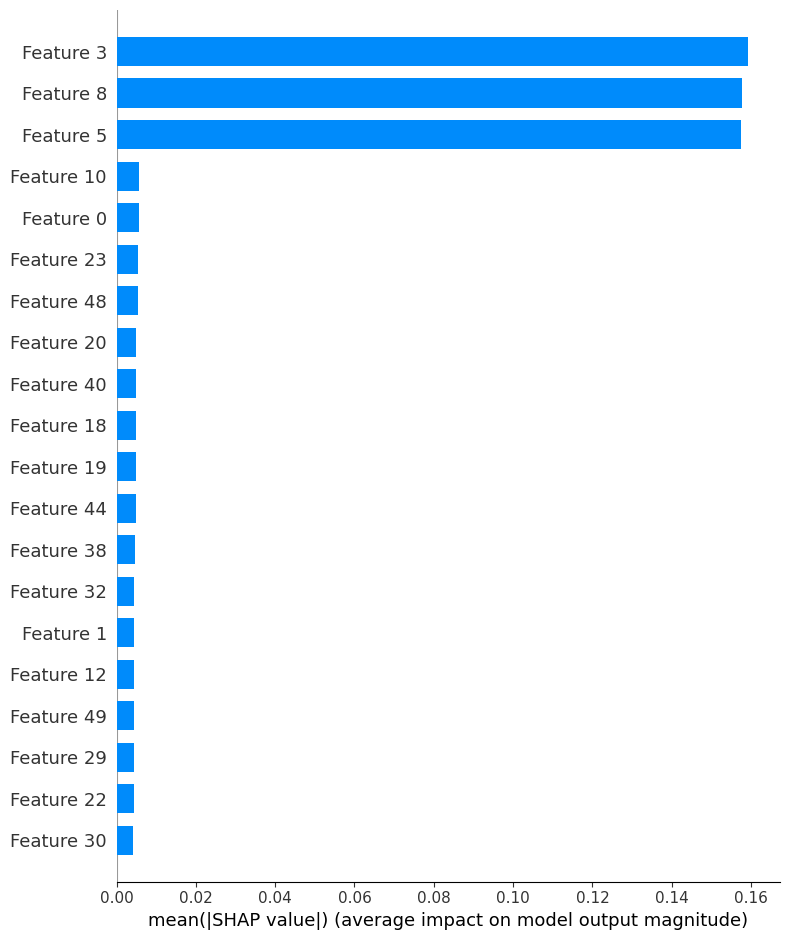

In [24]:
logistic_regr = linear_model.LogisticRegression()
logistic_regr.fit(X_trn, y_trn)
def print_accuracy(f):
    accuracy = np.mean(f(X_tst) == y_tst)
    print("Accuracy on test set = {:.2f}%".format(accuracy * 100))

print_accuracy(logistic_regr.predict)
ex = shap.KernelExplainer(logistic_regr.predict_proba, X_trn.numpy())
shap_values = ex.shap_values(X_tst.numpy())
shap.summary_plot(shap_values[1], X_tst.numpy(), plot_type="bar", title="Shapley Values for Positive Class")

In [25]:
model = MMBL(
    n_genes = X.shape[1],
    emb_dim = 16,
    mlp_channels = [X.shape[1], X.shape[1], 1],
    n_heads = 1,
)

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 20

In [27]:
# TODO  change accordingly
loss_fn = torch.nn.BCEWithLogitsLoss()
# loss_fn = torch.nn.MSELoss()

X_trn = utils.convert2tensor(X_trn)
y_trn = utils.convert2tensor(y_trn)
X_tst = utils.convert2tensor(X_tst)
y_tst = utils.convert2tensor(y_tst)

for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()

    # TODO change accordingly
    logits = model(X_trn)
    loss = loss_fn(logits.squeeze(), y_trn)
    # logits = model(X_trn)
    # loss = loss_fn(logits.squeeze(), y_trn)

    loss.backward()
    optimizer.step()

    # TODO change accordingly
    accuracy = (logits.sigmoid().round() == y_trn.unsqueeze(1)).float().mean()
    print(f'epoch {epoch}, loss {loss.item()}, trn accuracy {accuracy.item()}')
    # print(f'epoch {epoch}, loss {loss.item()}')

# test accuracy
model.eval()
# TODO change accordingly
# logits = model(X_tst).detach()
logits = model(X_tst).detach().squeeze()
accuracy = (logits.sigmoid().round() == y_tst).float().mean()
print(f'tst accuracy {accuracy.item():.3f}')
# print('Test MSE', torch.mean((logits.squeeze().detach() - y_tst)**2).item())

epoch 0, loss 0.6932029724121094, trn accuracy 0.53125
epoch 1, loss 0.6924160718917847, trn accuracy 0.5062500238418579
epoch 2, loss 0.6918336153030396, trn accuracy 0.5249999761581421
epoch 3, loss 0.6942533850669861, trn accuracy 0.4625000059604645
epoch 4, loss 0.6944447755813599, trn accuracy 0.4749999940395355
epoch 5, loss 0.6943579316139221, trn accuracy 0.5062500238418579
epoch 6, loss 0.6938914060592651, trn accuracy 0.4124999940395355
epoch 7, loss 0.6938477754592896, trn accuracy 0.48750001192092896
epoch 8, loss 0.6953662037849426, trn accuracy 0.4625000059604645
epoch 9, loss 0.6913416981697083, trn accuracy 0.5375000238418579
epoch 10, loss 0.6950405240058899, trn accuracy 0.5
epoch 11, loss 0.6954056024551392, trn accuracy 0.45625001192092896
epoch 12, loss 0.692751407623291, trn accuracy 0.5
epoch 13, loss 0.693795382976532, trn accuracy 0.4749999940395355
epoch 14, loss 0.6946658492088318, trn accuracy 0.5062500238418579
epoch 15, loss 0.6927098631858826, trn accurac

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
n_epochs = 20

In [29]:
# TODO  change accordingly
loss_fn = torch.nn.BCEWithLogitsLoss()
# loss_fn = torch.nn.MSELoss()

X_trn = utils.convert2tensor(X_trn)
y_trn = utils.convert2tensor(y_trn)
X_tst = utils.convert2tensor(X_tst)
y_tst = utils.convert2tensor(y_tst)

for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()

    # TODO change accordingly
    logits = model(X_trn)
    loss = loss_fn(logits.squeeze(), y_trn)
    # logits = model(X_trn)
    # loss = loss_fn(logits.squeeze(), y_trn)

    loss.backward()
    optimizer.step()

    # TODO change accordingly
    accuracy = (logits.sigmoid().round() == y_trn.unsqueeze(1)).float().mean()
    print(f'epoch {epoch}, loss {loss.item()}, trn accuracy {accuracy.item()}')
    # print(f'epoch {epoch}, loss {loss.item()}')

# test accuracy
model.eval()
# TODO change accordingly
# logits = model(X_tst).detach()
logits = model(X_tst).detach().squeeze()
accuracy = (logits.sigmoid().round() == y_tst).float().mean()
print(f'tst accuracy {accuracy.item():.3f}')
# print('Test MSE', torch.mean((logits.squeeze().detach() - y_tst)**2).item())

epoch 0, loss 0.6936501264572144, trn accuracy 0.5062500238418579
epoch 1, loss 0.691057562828064, trn accuracy 0.512499988079071
epoch 2, loss 0.6918883323669434, trn accuracy 0.5249999761581421
epoch 3, loss 0.6735358238220215, trn accuracy 0.543749988079071
epoch 4, loss 0.664986789226532, trn accuracy 0.706250011920929
epoch 5, loss 0.6813937425613403, trn accuracy 0.7562500238418579
epoch 6, loss 0.6838845610618591, trn accuracy 0.5375000238418579
epoch 7, loss 0.7044302821159363, trn accuracy 0.42500001192092896
epoch 8, loss 0.7876765131950378, trn accuracy 0.14374999701976776
epoch 9, loss 0.6905917525291443, trn accuracy 0.5375000238418579
epoch 10, loss 0.7377187013626099, trn accuracy 0.4437499940395355
epoch 11, loss 0.7216692566871643, trn accuracy 0.46875
epoch 12, loss 0.6018815636634827, trn accuracy 0.7562500238418579
epoch 13, loss 0.5725072026252747, trn accuracy 0.7875000238418579
epoch 14, loss 0.6867334842681885, trn accuracy 0.512499988079071
epoch 15, loss 0.642

In [30]:
model.eval()

MMBL(
  (module1): Module1(
    (gene_emb_vocab): Embedding(50, 16)
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
    )
    (conv): Conv1d(16, 1, kernel_size=(1,), stride=(1,))
  )
  (module3): MLP(
    (layers): Sequential(
      (0): Linear(in_features=50, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=1, bias=True)
    )
  )
)

In [31]:
_, attn = model.module1(X_trn, output_attn_scores=True)

In [32]:
attn = attn.detach().numpy()

In [33]:
attn = attn.mean(0)

In [34]:
gene_attn = attn.mean(0)

In [35]:
gene_attn

array([0.02053003, 0.01556957, 0.0268603 , 0.01664601, 0.01776213,
       0.01644435, 0.01775477, 0.01824432, 0.01550161, 0.03557958,
       0.02680481, 0.01730554, 0.01564788, 0.02170809, 0.01695464,
       0.01688779, 0.01938091, 0.01713709, 0.01599156, 0.02508232,
       0.01600469, 0.01570232, 0.02572244, 0.01986806, 0.01678439,
       0.0168745 , 0.03470605, 0.02019772, 0.01819478, 0.02203703,
       0.01971731, 0.0178719 , 0.0212521 , 0.02278773, 0.02546927,
       0.01744382, 0.02149729, 0.0288903 , 0.01618938, 0.01661011,
       0.01851208, 0.01884268, 0.02525351, 0.01585537, 0.02946352,
       0.01966156, 0.0163168 , 0.0160839 , 0.01520176, 0.01719432],
      dtype=float32)

In [36]:
attn

array([[0.01088136, 0.01595802, 0.01722813, ..., 0.02045589, 0.01599858,
        0.02412262],
       [0.02214251, 0.01549045, 0.03529665, ..., 0.01123764, 0.01095052,
        0.01241281],
       [0.01906012, 0.01801849, 0.01776078, ..., 0.02161967, 0.01835836,
        0.01826389],
       ...,
       [0.02124833, 0.0185927 , 0.02827924, ..., 0.02133341, 0.01874217,
        0.01910531],
       [0.01992425, 0.01959242, 0.02024369, ..., 0.01955741, 0.01584421,
        0.02043109],
       [0.0192912 , 0.01688817, 0.02893206, ..., 0.01784718, 0.01706075,
        0.01934211]], dtype=float32)

In [37]:
np.arange(50)[np.argsort(gene_attn)[::-1]]

array([ 9, 26, 44, 37,  2, 10, 22, 34, 42, 19, 33, 29, 13, 36, 32,  0, 27,
       23, 30, 45, 16, 41, 40,  7, 28, 31,  4,  6, 35, 11, 49, 17, 14, 15,
       25, 24,  3, 39,  5, 46, 38, 47, 20, 18, 43, 21, 12,  1,  8, 48])

In [38]:
# https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Diabetes%20regression.html
import time
from sklearn.model_selection import train_test_split
import shap

X, y = shap.datasets.diabetes()
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.2, random_state=0)

Root mean squared test error = 58.517171277315605


100%|██████████| 89/89 [00:06<00:00, 13.69it/s]


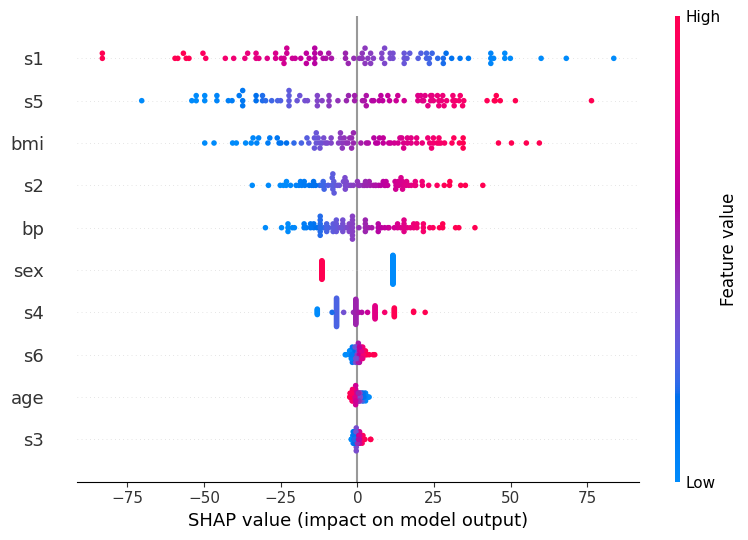

In [39]:
# rather than use the whole training set to estimate expected values, we summarize with
# a set of weighted kmeans, each weighted by the number of points they represent.
X_trn_summary = shap.kmeans(X_trn, 10)

def print_accuracy(f):
    print(
        "Root mean squared test error = {}".format(
            np.sqrt(np.mean((f(X_tst) - y_tst) ** 2))
        )
    )
    time.sleep(0.5)  # to let the print get out before any progress bars

shap.initjs()

lin_regr = linear_model.LinearRegression()
lin_regr.fit(X_trn, y_trn)

print_accuracy(lin_regr.predict)

ex = shap.KernelExplainer(lin_regr.predict, X_trn_summary)
shap_values = ex.shap_values(X_tst)
shap.summary_plot(shap_values, X_tst)

In [40]:
model = MMBL(
    n_genes = X.shape[1],
    emb_dim = 8,
    mlp_channels = [X.shape[1], 16, 1],
    n_heads = 1,
)

In [41]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
n_epochs = 20

In [42]:
# TODO  change accordingly
loss_fn = torch.nn.MSELoss()

X_trn = utils.convert2tensor(X_trn)
y_trn = utils.convert2tensor(y_trn)
X_tst = utils.convert2tensor(X_tst)
y_tst = utils.convert2tensor(y_tst)

for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()

    # TODO change accordingly
    logits = model(X_trn)
    loss = loss_fn(logits.squeeze(), y_trn)

    loss.backward()
    optimizer.step()

    # TODO change accordingly
    print(f'epoch {epoch}, loss {loss.item()}')

# test accuracy
model.eval()
# TODO change accordingly
logits = model(X_tst).detach().squeeze()
print('Test MSE', torch.mean((logits.squeeze().detach() - y_tst)**2).item())

epoch 0, loss 29135.765625
epoch 1, loss 29125.904296875
epoch 2, loss 29110.212890625
epoch 3, loss 29110.6796875
epoch 4, loss 29087.439453125
epoch 5, loss 29083.626953125
epoch 6, loss 29071.66015625
epoch 7, loss 29057.55859375
epoch 8, loss 29044.05859375
epoch 9, loss 29034.189453125
epoch 10, loss 29024.1015625
epoch 11, loss 29002.580078125
epoch 12, loss 29013.5546875
epoch 13, loss 29003.609375
epoch 14, loss 28993.08203125
epoch 15, loss 28983.9921875
epoch 16, loss 28938.541015625
epoch 17, loss 28937.548828125
epoch 18, loss 28921.982421875
epoch 19, loss 28945.439453125
Test MSE 28734.03125
